In [31]:
import networkx as nx
import networkit as nk
from utils import load_graph_v3, load_graph_v3_rustworkx
from network_utils import approx_average_shortest_path_length_nk, calculate_avg_clustering_coefficient_nk
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import nx_parallel as nxp
import rustworkx as rx
import powerlaw
import igraph as ig
import random
import scipy.stats as stats

In [32]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
PATH_TO_GRAPH = "spotify_graph_l0renzz_5.jsonl"
SAMPLE_SIZE = 10
SEED = 42
CUSTOM_COLOR = "#73D4A2"
sns.set_theme("paper")

In [34]:
R, id_map = load_graph_v3_rustworkx(PATH_TO_GRAPH)
R_undirected = R.to_undirected()

In [35]:

G = load_graph_v3(PATH_TO_GRAPH)

selfloops = list(nx.selfloop_edges(G))
print(f"Number of selfloops: {len(selfloops)}")
G.remove_edges_from(selfloops)

G_undirected = G.to_undirected()
G_nk = nk.nxadapter.nx2nk(G_undirected)


Number of selfloops: 62


In [36]:

print(f"Nodes: {G.number_of_nodes()}, Edges: {G.number_of_edges()}")
print(f"Rustworkx Nodes: {len(R.nodes())}, Edges: {len(R.edges())}")
user_indegree_series = pd.Series({n: G_undirected.nodes[n].get("followers_count", G_undirected.degree(n)) for n in G_undirected.nodes})


Nodes: 1077947, Edges: 4730357
Rustworkx Nodes: 1077947, Edges: 4730419


In [ ]:
#print users with highest indegree
top_users = user_indegree_series.sort_values(ascending=False).head(10)
top_users_out_vs_indegree = {}
for user_id in top_users.index:
    out_degree = G.out_degree(user_id)
    in_degree = G.in_degree(user_id)
    top_users_out_vs_indegree[user_id] = (out_degree, in_degree)
print("Top 10 users by followers count:")
for user_id, followers_count in top_users.items():
    print(f"User ID: {user_id}, Followers Count: {followers_count}")
    print(f"    Out-degree (following): {top_users_out_vs_indegree[user_id][0]}, In-degree (followers): {top_users_out_vs_indegree[user_id][1]}")

Top 10 users by followers count:
User ID: myplay.com, Followers Count: 736428.0
    Out-degree (following): 1, In-degree (followers): 0
User ID: coca-cola, Followers Count: 712690.0
    Out-degree (following): 1, In-degree (followers): 0
User ID: napstersean, Followers Count: 504002.0
    Out-degree (following): 1, In-degree (followers): 0
User ID: mejoreslistasspotify, Followers Count: 246284.0
    Out-degree (following): 1, In-degree (followers): 0
User ID: cl4pu66mupttwuzei265gpsjf, Followers Count: 211785.0
    Out-degree (following): 1, In-degree (followers): 0
User ID: capitolrecords, Followers Count: 202860.0
    Out-degree (following): 1, In-degree (followers): 0
User ID: 12100249023, Followers Count: 194234.0
    Out-degree (following): 10082, In-degree (followers): 1000
User ID: sharemyplaylists.com, Followers Count: 107705.0
    Out-degree (following): 3, In-degree (followers): 0
User ID: numerogroup, Followers Count: 96841.0
    Out-degree (following): 1, In-degree (followe

## NetworkKit

In [38]:
#print number of nodes and edges in the networkkit graph
print(f"Networkit Graph - Nodes: {G_nk.numberOfNodes()}, Edges: {G_nk.numberOfEdges()}")

Networkit Graph - Nodes: 1077947, Edges: 4580255


In [39]:
avg_local_clustering = calculate_avg_clustering_coefficient_nk(G_nk)
print(f"Average Local Clustering Coefficient (Networkit): {avg_local_clustering}")

Average Local Clustering Coefficient (Networkit): 0.05498852100052146


In [40]:
avg_shortest_path_length_nk = approx_average_shortest_path_length_nk(G_nk, SAMPLE_SIZE)
print(f"Approx. Average Shortest Path Length (Networkit, sampled from {SAMPLE_SIZE} nodes): {avg_shortest_path_length_nk["mean"]}") 

Approx. Average Shortest Path Length (Networkit, sampled from 10 nodes): 4.840465254785254


In [41]:
num_nodes = G_nk.numberOfNodes()
avg_degree = (2 * G_nk.numberOfEdges()) / G_nk.numberOfNodes()
k = int(avg_degree)
if k % 2 != 0:
    k += 1 
print(f"Creating regular lattice with {num_nodes} nodes and  {k} neighbors per side")

regular_lattice_generator = nk.generators.RegularRingLatticeGenerator(num_nodes, k)
G_regular_lattice = regular_lattice_generator.generate()
avg_random_local_clustering = calculate_avg_clustering_coefficient_nk(G_regular_lattice)
print(f"Average Local Clustering Coefficient (Regular Lattice): {avg_random_local_clustering}")

Creating regular lattice with 1077947 nodes and  8 neighbors per side
Average Local Clustering Coefficient (Regular Lattice): 0.7000000000000002


In [42]:
G_rand_curveball = nk.randomization.GlobalCurveball(G_nk, number_of_global_rounds=50)
G_rand_curveball.run()
G_randomized = G_rand_curveball.getGraph()
cc = nk.components.ConnectedComponents(G_randomized)
cc.run()
com_sizs = cc.getComponentSizes()
sizes = np.array(list(com_sizs.values()))
max_size = np.max(sizes)
print(f"Randomized Graph - Number of connected components: {len(com_sizs)}, Largest component size: {max_size}")

Randomized Graph - Number of connected components: 138572, Largest component size: 917739


In [43]:
avg_shortest_path_lengths = []
largest_component_sizes = []
for _ in range(10):
    G_rand_curveball = nk.randomization.GlobalCurveball(G_nk, number_of_global_rounds=50)
    G_rand_curveball.run()
    G_randomized = G_rand_curveball.getGraph()
    G_largest_cc = nk.components.ConnectedComponents(G_randomized).extractLargestConnectedComponent(G_randomized, compactGraph=True)
    largest_component_sizes.append(G_largest_cc.numberOfNodes())
    avg_shortest_path_length_nk = approx_average_shortest_path_length_nk(G_largest_cc, 10)
    avg_shortest_path_lengths.append(avg_shortest_path_length_nk["mean"])
avg_random_shortest_path_length = np.mean(avg_shortest_path_lengths)
avg_graph_size = np.mean(largest_component_sizes)
print(f"Approx. Average Shortest Path Length (Randomized Graphs, generated from graphs with average size of {avg_graph_size}: {avg_random_shortest_path_length}")

Approx. Average Shortest Path Length (Randomized Graphs, generated from graphs with average size of 917321.0: 4.022499365010912


# Omega yeaaah

In [44]:
omega = (avg_random_shortest_path_length / avg_shortest_path_length_nk["mean"]) - (avg_local_clustering / avg_random_local_clustering)
print(f"Omega: {omega}")

Omega: 0.9257247999044036


## Power Law Test

In [68]:
followers_data = user_indegree_series[(user_indegree_series > 0)].values

fit = powerlaw.Fit(followers_data, discrete=True)

print("Power Law Analysis Results:")
print(f"Alpha (power law exponent): {fit.power_law.alpha:.3f}")
print(f"xmin: {fit.power_law.xmin:.2f}")
print(f"Data points used: {len(followers_data[followers_data >= fit.power_law.xmin])}/{len(followers_data)}")

Calculating best minimal value for power law fit


Fitting xmin: 100%|██████████| 4913/4913 [00:40<00:00, 121.50it/s]


Power Law Analysis Results:
Alpha (power law exponent): 1.859
xmin: 30.00
Data points used: 440913/1040216


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


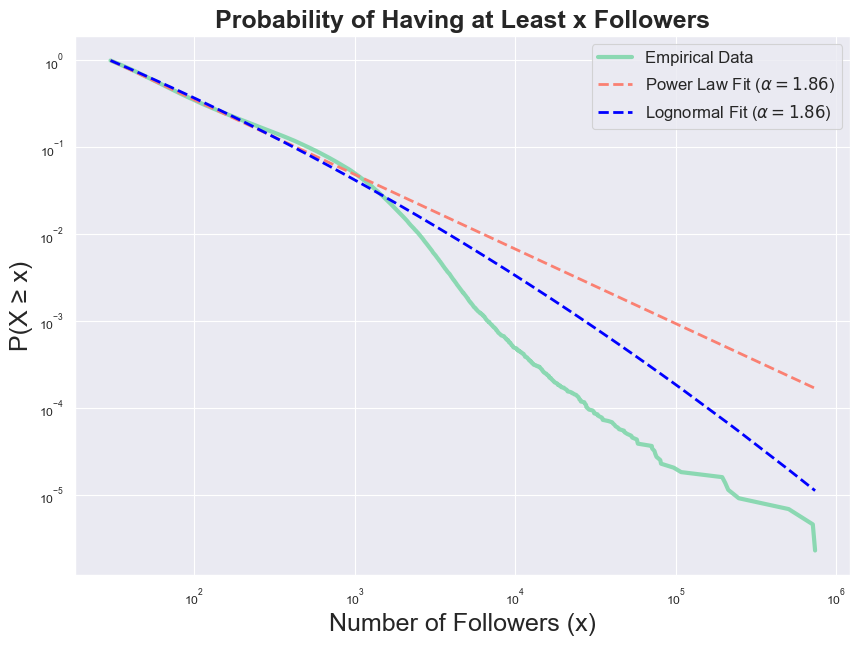

In [69]:
plt.figure(figsize=(10, 7))
fit.plot_ccdf(original_data=False,
              color=CUSTOM_COLOR, 
              linewidth=3, 
              alpha=0.8, 
              label="Empirical Data")

fit.power_law.plot_ccdf(color='salmon', linestyle='--', linewidth=2, label=f'Power Law Fit ($\\alpha={fit.power_law.alpha:.2f}$)')
fit.lognormal.plot_ccdf(color='blue', linestyle='--', linewidth=2, label=f'Lognormal Fit ($\\alpha={fit.power_law.alpha:.2f}$)')
plt.title("Probability of Having at Least x Followers", fontsize=18, fontweight='bold')
plt.xlabel("Number of Followers (x)", fontsize=18)
plt.ylabel("P(X ≥ x)", fontsize=18)
plt.legend(frameon=True, fontsize=12)

plt.savefig("followers_ccdf_powerlaw.eps", format="eps", transparent=False, bbox_inches='tight')
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


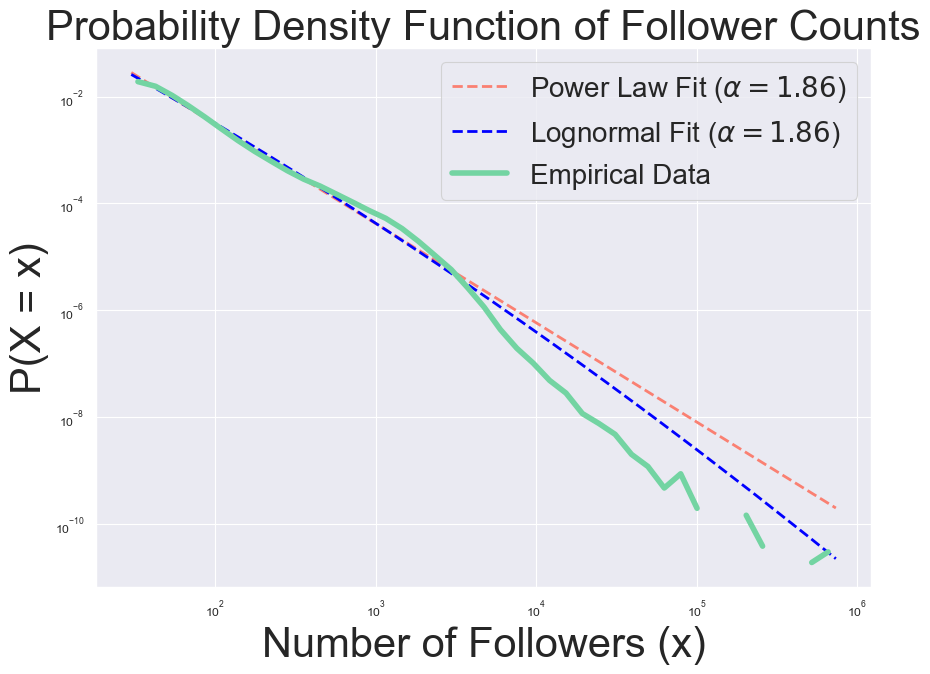

In [70]:
plt.figure(figsize=(10, 7))
fit.power_law.plot_pdf(color='salmon', linestyle='--', linewidth=2, label=f'Power Law Fit ($\\alpha={fit.power_law.alpha:.2f}$)')
fit.lognormal.plot_pdf(color='blue', linestyle='--', linewidth=2, label=f'Lognormal Fit ($\\alpha={fit.power_law.alpha:.2f}$)')
fit.plot_pdf(original_data=False,
              color=CUSTOM_COLOR, 
              linewidth=4, 
              label="Empirical Data")

plt.title("Probability Density Function of Follower Counts", fontsize=30)
plt.xlabel("Number of Followers (x)", fontsize=30)
plt.ylabel("P(X = x)", fontsize=30)
plt.legend(frameon=True, fontsize=20)

plt.savefig("followers_pdf_powerlaw.eps", format="eps", transparent=False, bbox_inches='tight')
plt.show()

In [71]:
distributions = ['power_law', 'lognormal', 'exponential', 'truncated_power_law', 'stretched_exponential']
results = {}
for dist in distributions:
    for other_dist in distributions:
        if dist != other_dist:
            if (dist, other_dist) not in results and (other_dist, dist) not in results:
                R_, p = fit.distribution_compare(dist, other_dist, normalized_ratio=True)
                results[(dist, other_dist)] = (R_, p)

for (dist_pair, (R_, p)) in results.items():
    if R_ == max([r for (d1, d2), (r, _) in results.items() if dist_pair[0] in (d1, d2) or dist_pair[1] in (d1, d2)]):
        print(f"Highest R for {dist_pair[0]} vs {dist_pair[1]}: R={R_:.3f}, p={p:.12f}")

/Users/lorenz/uni/spotify-friends/.venv/lib/python3.13/site-packages/powerlaw/distributions.py:808: UserWarning: Fitted parameters are very close to the edge of parameter ranges for distribution exponential; consider changing these ranges.
  warnings.warn(f'Fitted parameters are very close to the edge of parameter ranges for distribution {self.name}; consider changing these ranges.')
/Users/lorenz/uni/spotify-friends/.venv/lib/python3.13/site-packages/powerlaw/distributions.py:808: UserWarning: Fitted parameters are very close to the edge of parameter ranges for distribution truncated_power_law; consider changing these ranges.
  warnings.warn(f'Fitted parameters are very close to the edge of parameter ranges for distribution {self.name}; consider changing these ranges.')


Highest R for lognormal vs exponential: R=97.531, p=0.000000000000
Highest R for truncated_power_law vs stretched_exponential: R=19.854, p=0.000000000000


In [72]:
#calculate Proportion of indegree to followers count by bins:



In [73]:
print(avg_local_clustering)
print(avg_random_local_clustering)

0.05740065821947645
0.7


In [ ]:
#comparing clustering coeff funcs
from network_utils import calculate_avg_clustering_coefficient_nk
avg_local_clustering_nx = nx.approximation.average_clustering(G_undirected, trials=SAMPLE_SIZE*100000, seed=SEED)
avg_local_clustering_own = calculate_avg_clustering_coefficient_nk(G_nk)
avg_local_clustering_approx_nk = nk.globals.ClusteringCoefficient.approxAvgLocal(G_nk, trials=1000)
avg_local_clustering_seq = nk.globals.ClusteringCoefficient.sequentialAvgLocal(G_nk)

print("nx: ", avg_local_clustering_nx)
print("own: ", avg_local_clustering_own)
print("approx nk: ", avg_local_clustering_approx_nk)
print("seq: ", avg_local_clustering_seq)


nx:  0.054737
own:  {'mean': np.float64(0.05498852100052146), 'std_dev': np.float64(0.1878017543782053), 'count': 1077947}
approx nk:  0.239
seq:  0.23271541738591434


# Calculating small worldedness (outdated NetworkX version)

## Average Clustering

In [74]:
C_real = nx.approximation.average_clustering(G_undirected, trials=SAMPLE_SIZE*10000, seed=SEED)

# Calculating small worldedness

In [75]:
from network_utils import analyze_path_lengths_rx

L_real_directed, std_dev_directed, sample_size_directed = analyze_path_lengths_rx(R, num_samples=10).values()
L_real_undirected, std_dev_undirected, sample_size_undirected = analyze_path_lengths_rx(R_undirected, num_samples=SAMPLE_SIZE).values()
print(f"Estimated Average Length: {L_real_directed:.4f}(directed), {L_real_undirected:.4f}(undirected)")
print(f"Standard Deviation:       {std_dev_directed:.4f} (directed), {std_dev_undirected:.4f} (undirected)")
print(f"Total Paths Sampled:      {sample_size_directed} (directed), {sample_size_undirected} (undirected)")

Estimated Average Length: 8.0326(directed), 4.6934(undirected)
Standard Deviation:       1.9532 (directed), 0.9066 (undirected)
Total Paths Sampled:      415040 (directed), 107794600 (undirected)


## Generating Null Models

In [76]:
NUM_RANDOM_GRAPHS = 10
CONFIDENCE_LEVEL = 0.95

L_real = L_real_undirected
avg_degree_real = 2 * R_undirected.num_edges() / R_undirected.num_nodes()
print(f"Real Network - C: {C_real:.6f}, L: {L_real:.4f}, Avg Degree: {avg_degree_real:.4f}")

n = R_undirected.num_nodes()
m = R_undirected.num_edges()
p = (2 * m) / (n * (n - 1)) if n > 1 else 0 # --> see https://www.rustworkx.org/apiref/rustworkx.undirected_gnp_random_graph.html#rustworkx-undirected-gnp-random-graph
                                            # "In general, for any probability , the expected number of edges returned is . If  or , the returned graph is not random and will always be an empty or a complete graph respectively."

print(f"Generating {NUM_RANDOM_GRAPHS} random graphs with n={n}, p={p:.8f}...")

C_rands = []
L_rands = []
avg_degrees = []

for i in range(NUM_RANDOM_GRAPHS):
    R_rand = rx.undirected_gnp_random_graph(n, p, seed=SEED+i if SEED else None)
    l_rand_est, _, _ = analyze_path_lengths_rx(
        R_rand, 
        num_samples=10,
        seed=SEED+i if SEED else None
    ).values()
    L_rands.append(l_rand_est)
    avg_degree = 2 * R_rand.num_edges() / R_rand.num_nodes()
    avg_degrees.append(avg_degree)
    
    # Estimate C_rand
    # We  use the theoretical value: C_rand is approx. p
    c_rand_est = p
    C_rands.append(c_rand_est)

def calculate_ci(data, confidence=0.95):
    a = 1.0 * np.array(data, dtype=float)
    n = len(a)
    m, se = np.mean(a), stats.sem(a)
    if n >= 30:
        dist_func = stats.norm.ppf
    else:
        dist_func = lambda q: stats.t.ppf(q, n-1)
    h = se * dist_func((1 + confidence) / 2.)
    
    return m, m-h, m+h

L_rand_mean, L_rand_lower, L_rand_upper = calculate_ci(L_rands, CONFIDENCE_LEVEL)
avg_degree_mean, avg_degree_lower, avg_degree_upper = calculate_ci(avg_degrees, CONFIDENCE_LEVEL)
C_rand_mean, C_rand_lower, C_rand_upper = calculate_ci(C_rands, CONFIDENCE_LEVEL)

print(f"\nRandom Networks with a {int(CONFIDENCE_LEVEL*100)}% Confidence Interval:")
print(f"L_rand: {L_rand_mean:.4f}  [{L_rand_lower:.4f}, {L_rand_upper:.4f}]")
print(f"Avg Degree Rand: {avg_degree_mean:.4f}  [{avg_degree_lower:.4f}, {avg_degree_upper:.4f}]")
print(f"C_rand: {C_rand_mean:.6f}  [{C_rand_lower:.6f}, {C_rand_upper:.6f}]")
print(f"Theoretical C_rand (~p): {p:.6f}")

gamma = C_real / C_rand_mean if C_rand_mean > 0 else 0
lam = L_real / L_rand_mean if L_rand_mean > 0 else 0
sigma = gamma / lam if lam > 0 else 0

print("\n" + "="*40)
print(f"Results:")
print(f"Sigma (Gamma/Lambda): {sigma:.4f}")
print("="*40)

is_L_distinct = not (L_rand_lower <= L_real <= L_rand_upper)
is_C_distinct = not (C_rand_lower <= C_real <= C_rand_upper)

Real Network - C: 0.054418, L: 4.6934, Avg Degree: 8.7767
Generating 10 random graphs with n=1077947, p=0.00000814...

Random Networks with a 95% Confidence Interval:
L_rand: 6.6314  [6.6039, 6.6589]
Avg Degree Rand: 8.7767  [8.7735, 8.7799]
C_rand: 0.000008  [0.000008, 0.000008]
Theoretical C_rand (~p): 0.000008

Results:
Sigma (Gamma/Lambda): 9443.3719


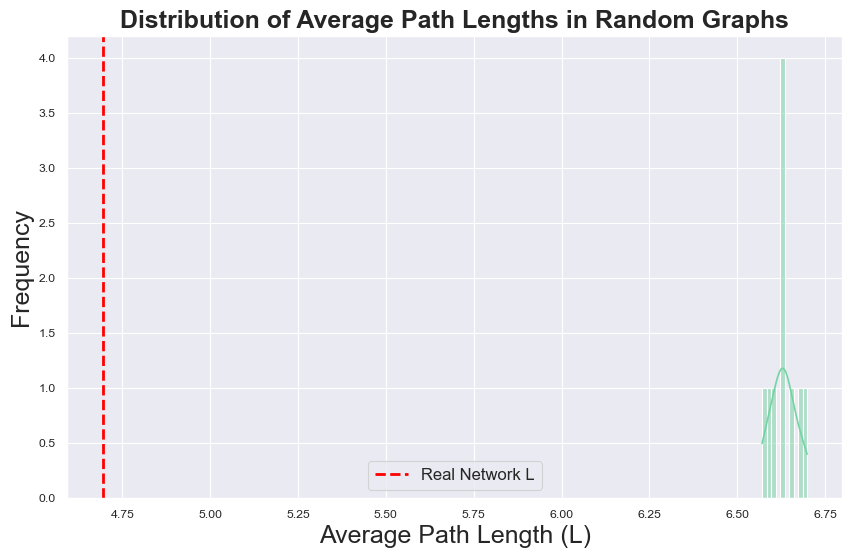

In [77]:
#plot a histogram of all trials
plt.figure(figsize=(10, 6))
sns.histplot(L_rands, bins=10, kde=True, color=CUSTOM_COLOR)
plt.axvline(L_real, color='red', linestyle='--', linewidth=2, label='Real Network L')
plt.title("Distribution of Average Path Lengths in Random Graphs", fontsize=18, fontweight='bold')
plt.xlabel("Average Path Length (L)", fontsize=18)
plt.ylabel("Frequency", fontsize=18)
plt.legend(frameon=True, fontsize=12)

## Degree

In [78]:
degrees = [d for n, d in G.degree()]
d_max = max(degrees)
d_avg = np.mean(degrees)
print(d_avg, d_max)

8.776604044540223 11082


## Clustering

In [79]:
transitivity = rx.digraph_transitivity(R)

In [80]:
print(transitivity)

0.03731783068878366


## Density

In [81]:
density = nx.density(G)
print(f"Density: {density:.6f}")

Density: 0.000004


## Transitivity

In [ ]:
transitivity = nxp.betweenness_centrality(G)
print(f"Transitivity: {transitivity:.6f}")

In [ ]:
# Skip those nodes who presumably don't follow anyone
G_without_users_who_are_not_followed = G.subgraph([n for n in G.nodes if G.in_degree(n) > 0]).copy()
reciprocity = nx.reciprocity(G_without_users_who_are_not_followed)
print(f"Reciprocity: {reciprocity:.4f}")

Reciprocity: 0.2439
